In [1]:
%matplotlib inline

import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.misc import imresize
from PIL import Image

from torch.autograd import Variable
from torch import optim
from torchvision.models import resnet101
from torchvision.models import vgg16
from torchvision import models, transforms

SEED = 41

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [2]:
# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels     = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [3]:
# number of labels
print(len(list(labels.items())))

1000


In [4]:
# let's look at 5 of 1000 labels
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


In [3]:
# helper methods
def postprocess(img):
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype(np.uint8)

    return img

In [4]:
# pick a single class
label_index = 146

In [ ]:
# pretrained net
# model = resnet101(pretrained=True)

In [5]:
# define input
img       = Image.open('sample_images/albatross.jpg')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

img = preprocess(img).unsqueeze(0)
img.requires_grad_(True);

In [6]:
# define target
y   = torch.LongTensor([label_index])

In [8]:
scores = model(img) 
scores = scores.gather(1, y.view(-1, 1)).squeeze()

# backward pass
# scores.backward(torch.ones(scores.shape))
scores.backward()

In [9]:
saliency_maps      = img.grad.data
saliency_maps      = saliency_maps.abs()
saliency_maps, idx = torch.max(saliency_maps, dim = 1)    # get max abs from all (3) channels

In [10]:
def show_saliency_maps(images, saliency_maps):
    N = len(images) # number of images
    
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(postprocess(images[0].data.squeeze(0).numpy().transpose(1, 2, 0)))
        plt.axis('off')
        
        plt.subplot(2, N, N + i + 1)
        plt.imshow(postprocess(saliency_maps[i].squeeze(0).numpy()), cmap = plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    
    plt.show()

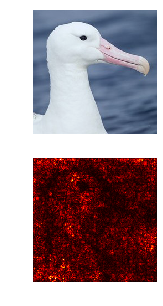

In [11]:
show_saliency_maps([img], [saliency_maps])

### Class Model Visualization

Class score for right class: 102.44805145263672
Max scores for rest of the classes: 79.156005859375
****************************************************************************************************
Class score for right class: 100.64107513427734
Max scores for rest of the classes: 78.63589477539062
****************************************************************************************************
Class score for right class: 98.36233520507812
Max scores for rest of the classes: 76.7540512084961
****************************************************************************************************


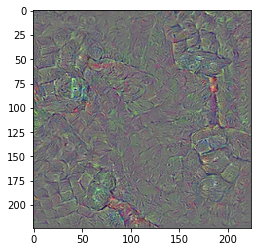

In [153]:
input_image       = np.zeros((224, 224, 3))
mean_train_images = np.array([0.485, 0.456, 0.406])
label_index = 543

input_image = input_image + mean_train_images
input_image = input_image.transpose(2,1,0)
input_image = torch.Tensor(input_image).cuda().unsqueeze(0)
input_image.requires_grad = True

model = model.cuda()
model.eval()

optimizer = optim.SGD([input_image], lr=.1)
reg = .6

iterations = 2000
losses     = []

for i in range(iterations):

    output      = model(input_image)
    class_score = output[0][label_index]
    
    loss = (reg * (torch.norm(input_image, 2) ** 2)  - class_score).cuda()
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    losses.append(loss.item())
    
    if i > 0 and i % 500 == 0:
        cs = output[0].cpu().detach().numpy()
        cs = np.delete(cs, label_index)
        
        print('Class score for right class: {}'.format(class_score))
        print('Max scores for rest of the classes: {}'.format(np.max(cs)))
        print('*' * 100)
    
output_image = input_image.data.squeeze(0)
output_image = torch.transpose(output_image, 2, 0).cpu().detach().numpy()
output_image = postprocess(output_image)

plt.imshow(output_image)

Class score for right class: 56.52389144897461
Max scores for rest of the classes: 42.898590087890625
****************************************************************************************************
Class score for right class: 61.6749382019043
Max scores for rest of the classes: 48.05744552612305
****************************************************************************************************
Class score for right class: 49.44182586669922
Max scores for rest of the classes: 38.852577209472656
****************************************************************************************************
Class score for right class: 53.253177642822266
Max scores for rest of the classes: 42.89862060546875
****************************************************************************************************
Class score for right class: 74.9372787475586
Max scores for rest of the classes: 62.25703430175781
******************************************************************************************

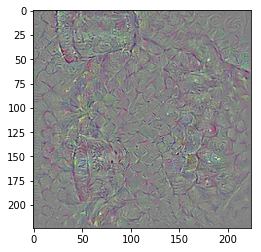

In [154]:
input_image       = np.zeros((224, 224, 3))
mean_train_images = np.array([0.485, 0.456, 0.406])
label_index = 968

input_image = input_image + mean_train_images
input_image = input_image.transpose(2,1,0)
input_image = torch.Tensor(input_image).cuda().unsqueeze(0)
input_image.requires_grad = True

model = model.cuda()
model.eval()

optimizer = optim.SGD([input_image], lr=.1)
reg = .6

iterations = 4000
losses     = []

for i in range(iterations):

    output      = model(input_image)
    class_score = output[0][label_index]
    
    loss = (reg * (torch.norm(input_image, 2) ** 2)  - class_score).cuda()
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    losses.append(loss.item())
    
    if i > 0 and i % 500 == 0:
        cs = output[0].cpu().detach().numpy()
        cs = np.delete(cs, label_index)
        
        print('Class score for right class: {}'.format(class_score))
        print('Max scores for rest of the classes: {}'.format(np.max(cs)))
        print('*' * 100)
    
output_image = input_image.data.squeeze(0)
output_image = torch.transpose(output_image, 2, 0).cpu().detach().numpy()
output_image = postprocess(output_image)

plt.imshow(output_image)

In [7]:
grad_dict = {}

def fc_hook(layer_name, grad_input, grad_output):
    layer_name = str(layer_name)
    
    grad_dict[layer_name] = {}
    grad_dict[layer_name]["grad_input"] = []
    grad_dict[layer_name]["grad_output"] = []

    grad_dict[layer_name]["grad_input"].append(grad_input)
    grad_dict[layer_name]["grad_output"].append(grad_output)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.model           = vgg16()
        self.fc1_hook_handle = self.model.features[11].register_backward_hook(self.fc1_backward_hook)
    
    def forward(self, x):
        return self.model(x)
    
    def fc1_backward_hook(self, module, grad_input, grad_output):
        fc_hook(module, grad_input, grad_output)

In [32]:
# %%time

model  = Net().cuda()
scores = model(img.cuda())
model.train()

loss_func = torch.nn.CrossEntropyLoss().cuda()
loss      = loss_func(scores, y.cuda())
loss.backward()

In [33]:
loss_grad_with_output = grad_dict['ReLU(inplace)']['grad_output'][0][0]

In [34]:
layer_1_output = model.model.features[0](img.cuda())
layer_2_output = model.model.features[1](layer_1_output)
layer_3_output = model.model.features[2](layer_2_output)
layer_4_output = model.model.features[3](layer_3_output)
layer_5_output = model.model.features[4](layer_4_output)
layer_6_output = model.model.features[5](layer_5_output)
layer_7_output = model.model.features[6](layer_6_output)
layer_8_output = model.model.features[7](layer_7_output)
layer_9_output = model.model.features[8](layer_8_output)
layer_10_output = model.model.features[9](layer_9_output)
layer_11_output = model.model.features[10](layer_10_output)
layer_12_output = model.model.features[11](layer_11_output)

In [35]:
layer_12_output[(layer_12_output <= 0) & (loss_grad_with_output <= 0)] = 0

In [36]:
conv_weights = model.model.features[10].weight
conv_weights = torch.transpose(conv_weights, 0, 1)

In [37]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [38]:
const_img = F.conv2d(layer_12_output, conv_weights, padding=1).squeeze(0)
const_img = to_grayscale(const_img)
const_img = const_img.cpu().detach().numpy()
const_img = postprocess(const_img)

In [21]:
plt.imshow(const_img, cmap='gray')

NameError: name 'const_img' is not defined

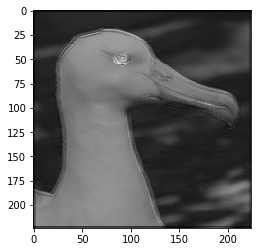

In [167]:
plt.imshow(const_img, cmap='gray')

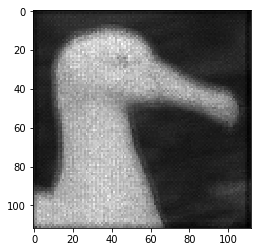

In [24]:
plt.imshow(const_img, cmap='gray')

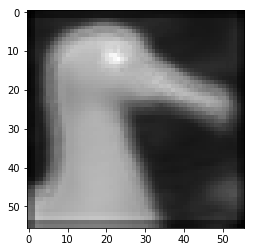

In [31]:
plt.imshow(const_img, cmap='gray')

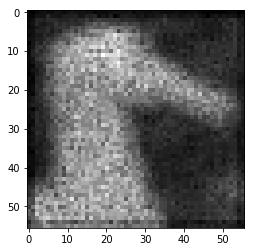

In [39]:
plt.imshow(const_img, cmap='gray')